<h1>Лабораторная работа №2</h1>

<h3>Тертычный Олег М8О-303Б-23</h3>

In [60]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [61]:
import os
from pathlib import Path
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from catboost import CatBoostClassifier, Pool, cv


In [62]:
import os
from pathlib import Path

IN_COLAB = "COLAB_GPU" in os.environ or "google.colab" in str(get_ipython())

if not IN_COLAB:
    ROOT = Path.cwd()

    if ROOT.name == "lab02":
        LAB_ROOT = ROOT
    elif (ROOT / "lab02").exists():
        LAB_ROOT = ROOT / "lab02"
    elif ROOT.name == "notebooks":
        LAB_ROOT = ROOT.parent
    else:
        raise FileNotFoundError("Не нашёл папку lab02 от текущей директории.")

    DATA_RAW = LAB_ROOT / "data" / "raw"
    DATA_RAW.mkdir(parents=True, exist_ok=True)

    csv_path = DATA_RAW / "telco.csv"

else:
    from urllib.request import urlretrieve

    url = "https://raw.githubusercontent.com/OlegTertychnyi/ML-labs-Tert/main/lab02/data/raw/telco.csv"
    csv_path = Path("/content/telco.csv")

    if not csv_path.exists():
        urlretrieve(url, csv_path)
        print("✔ Dataset downloaded to Colab")

csv_path


PosixPath('/home/optert/ML-labs-Tert/lab02/data/raw/telco.csv')

В этом блоке мы загружаем датасет и выполняем первичный осмотр структуры данных.

In [63]:
df = pd.read_csv(csv_path)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


По результатам первичного осмотра видно, что большинство признаков имеют тип object, а столбец TotalCharges, хотя выглядит числовым, содержит «грязные» значения и загружается как строковый. Его необходимо очистить и привести к числовому типу. Поле customerID является идентификатором и в моделировании не используется, а Churn позже будет преобразован в 0/1.

In [65]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = (df["Churn"] == "Yes").astype(int)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [66]:
print("Размеры:", df.shape)
df.info()

Размеры: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

Выделяем target и разделяем признаки на числовые и категориальные

In [67]:
TARGET = "Churn"
ID_COLS = ["customerID"] if "customerID" in df.columns else []

X = df.drop(columns=[TARGET] + ID_COLS)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_cols, cat_cols

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

Проверяем количество пропущенных значений. Как будет видно их нет, либо же есть, но в качестве скрытых пропусков

In [68]:
df.isna().sum().sort_values(ascending=False)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Смотрим на статистику по признакам.

In [69]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80


In [70]:
df[cat_cols].describe().T

,count,unique,top,freq
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095
TechSupport,7043,3,No,3473


 По числовым признакам заметен широкий разброс по tenure и TotalCharges, что отражает разный срок обслуживания клиентов. MonthlyCharges распределён достаточно равномерно вокруг среднего значения. Среди категориальных признаков преобладают значения «No» для дополнительных сервисов и контракт «Month-to-month», что может быть связано с более высоким риском ухода.

Выводим гистограммы числовых признаков

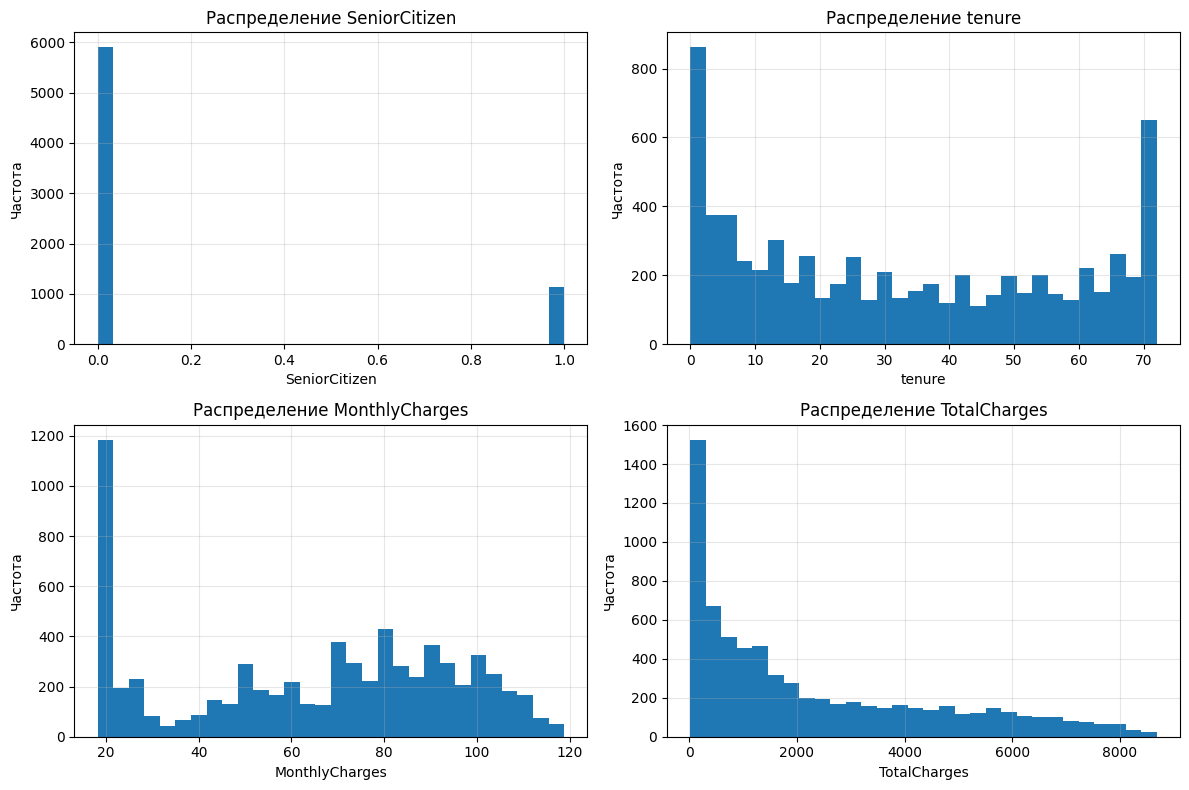

In [71]:
n = len(num_cols)
rows = (n + 1) // 2

fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=30)
    axes[i].set_title(f"Распределение {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Частота")
    axes[i].grid(alpha=0.3)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


По SeniorCitizen видно сильное смещение: подавляющее большинство клиентов — не пенсионеры. tenure распределён неравномерно, с большим числом новых клиентов и пиком среди долгосрочных. MonthlyCharges имеет широкий диапазон значений, что отражает разные наборы услуг. TotalCharges сильно скошен вправо: у большинства клиентов накопленная стоимость услуг невысокая, а большие значения встречаются реже.

Теперь рассмотрим распределение категориальных признаков.

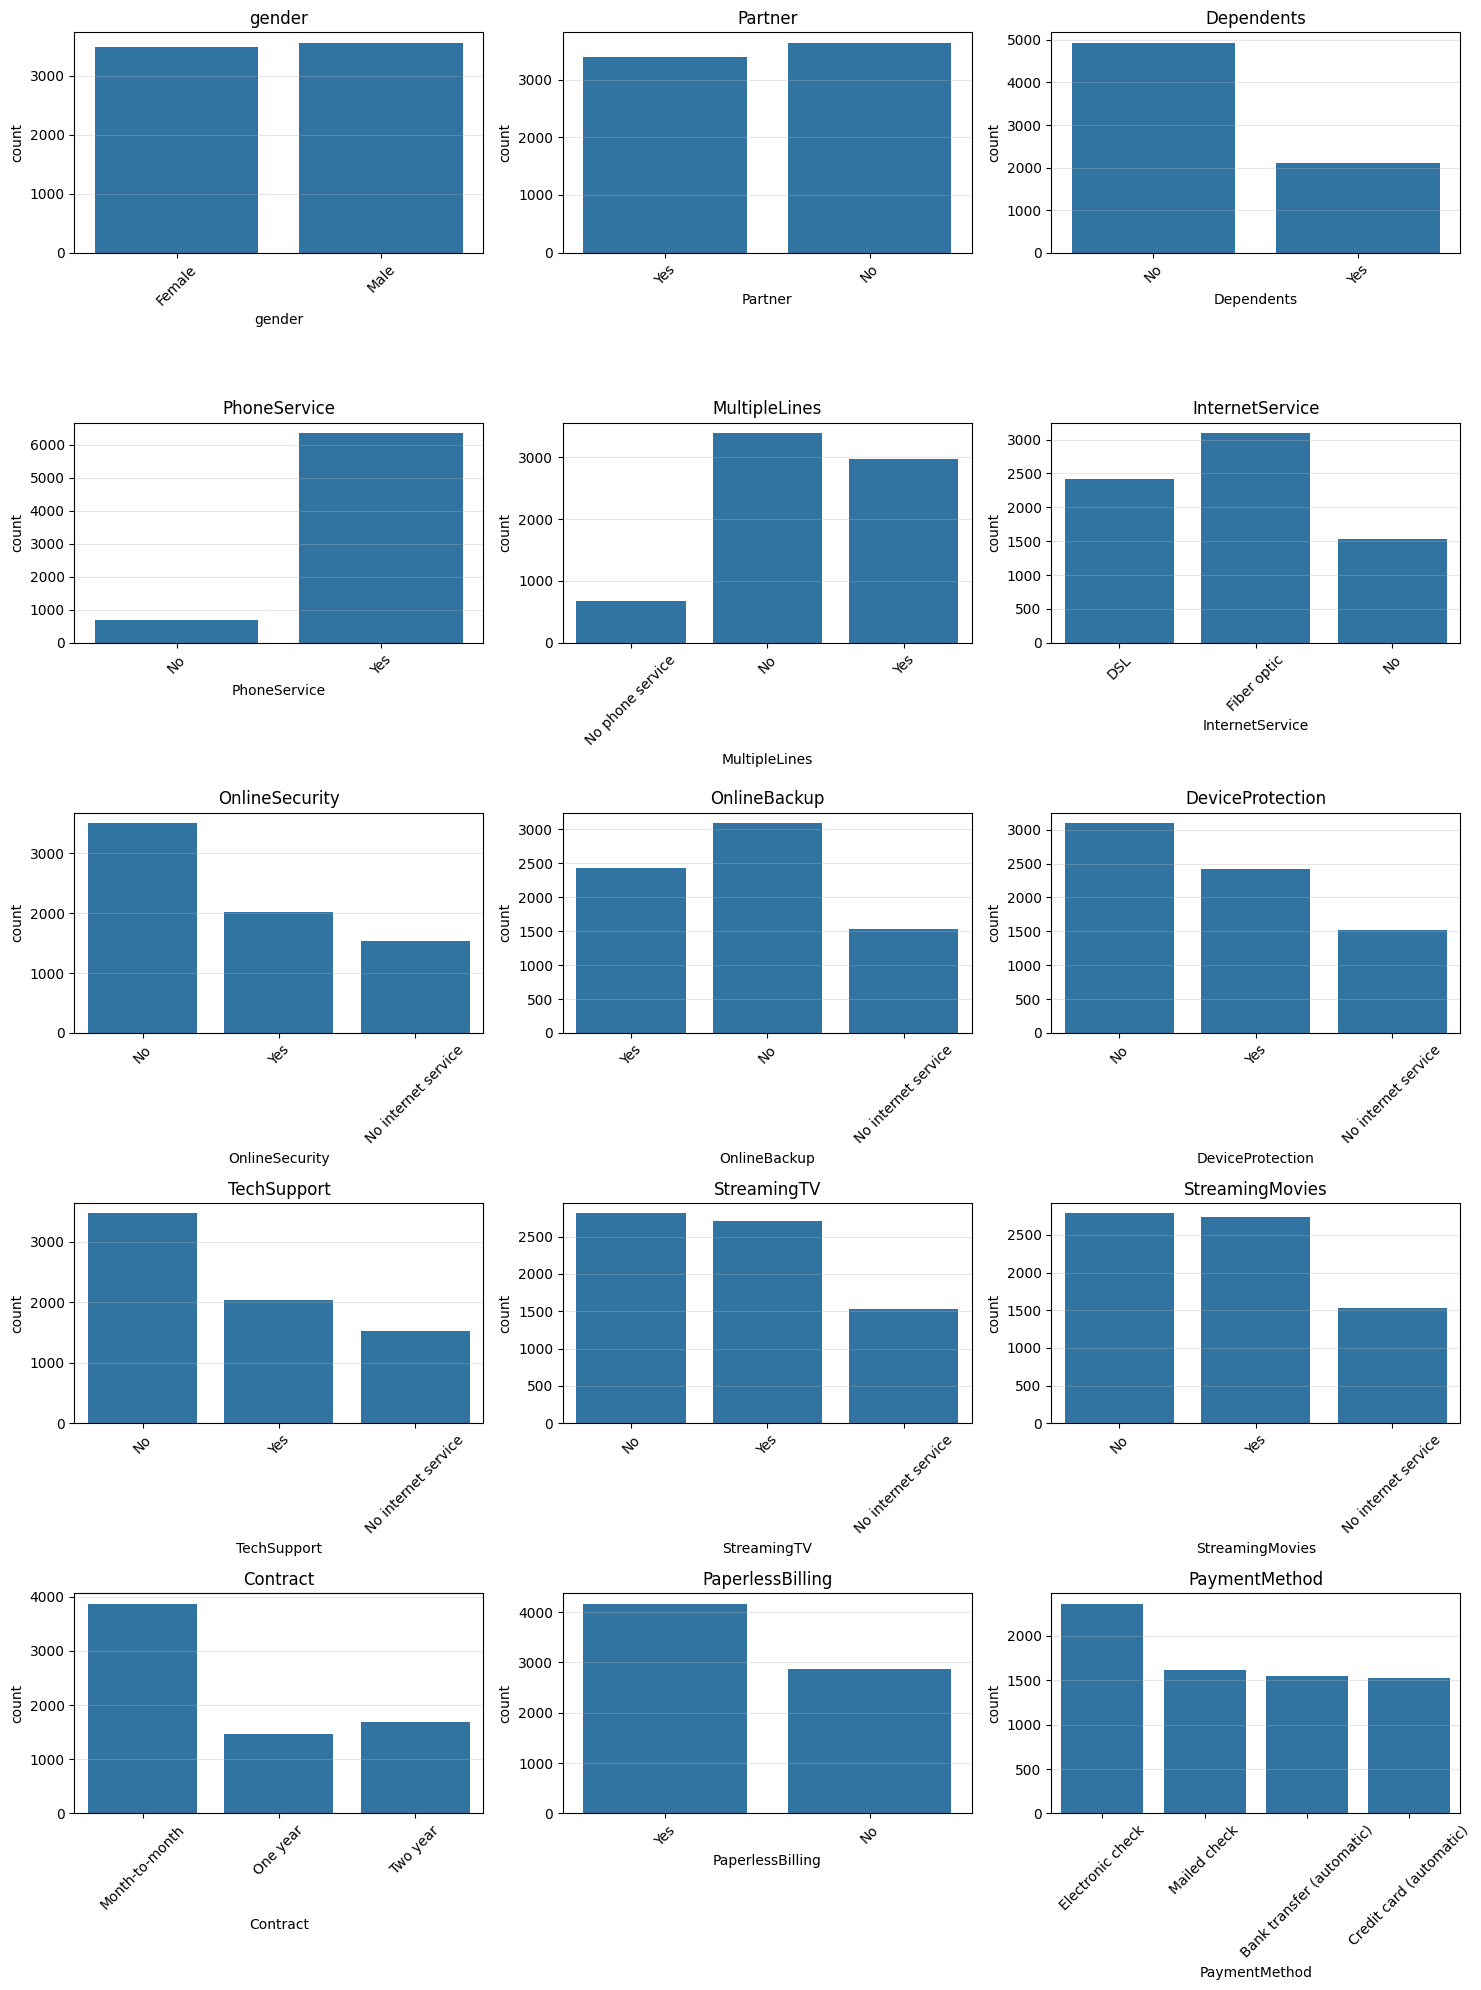

In [72]:
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45, labelrotation=45)
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(cat_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


Видно, что по многим сервисам преобладает значение «No» — большинство клиентов не используют дополнительные услуги вроде OnlineSecurity, TechSupport или DeviceProtection. Основной тип контракта — «Month-to-month», что обычно связано с более высокой склонностью к уходу. Также заметно, что наиболее популярный способ оплаты — Electronic check.

Попарные отношения между числовыми признаками

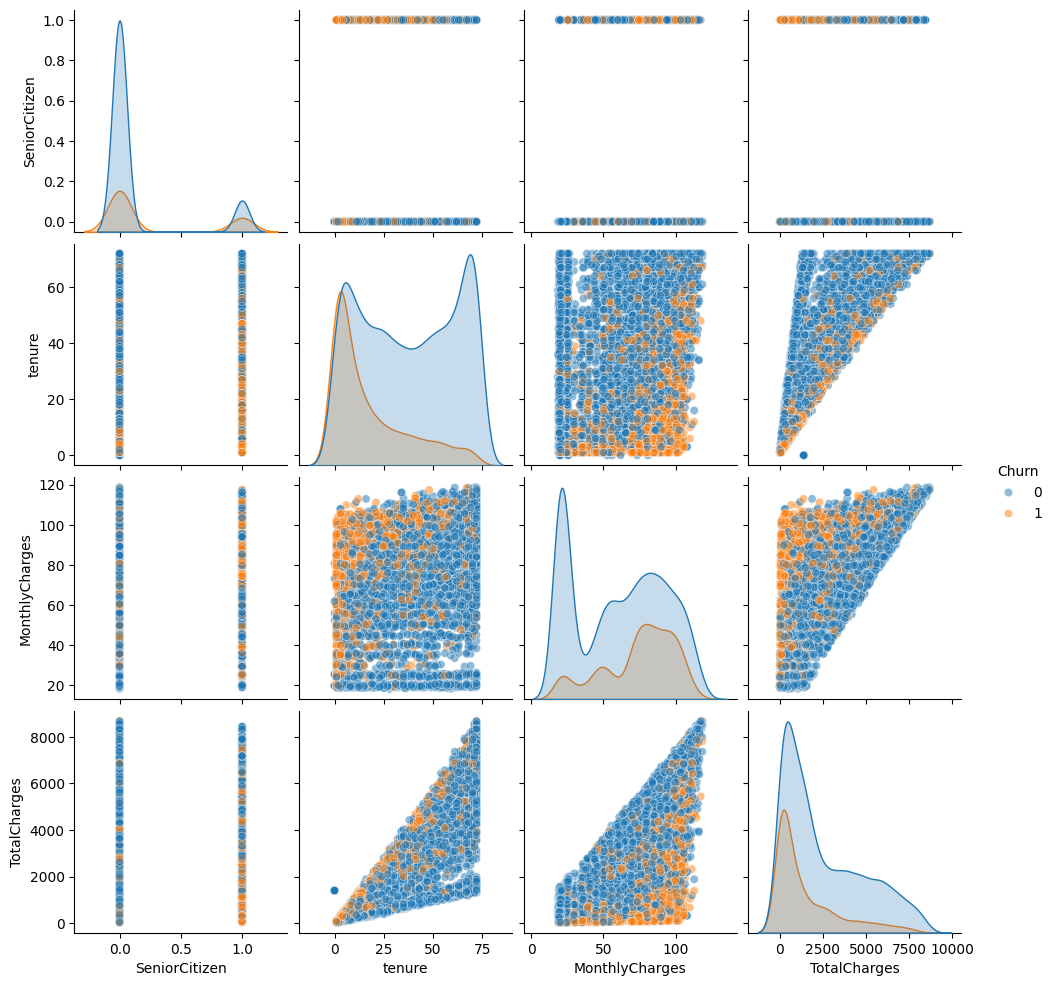

In [74]:
sns.pairplot(df[num_cols + ['Churn']], hue='Churn', plot_kws={'alpha': 0.5})
plt.show()

По диаграммам заметно, что клиенты с малым сроком обслуживания и низкими накопленными платежами чаще относятся к группе churn, что подтверждает важность этих признаков.

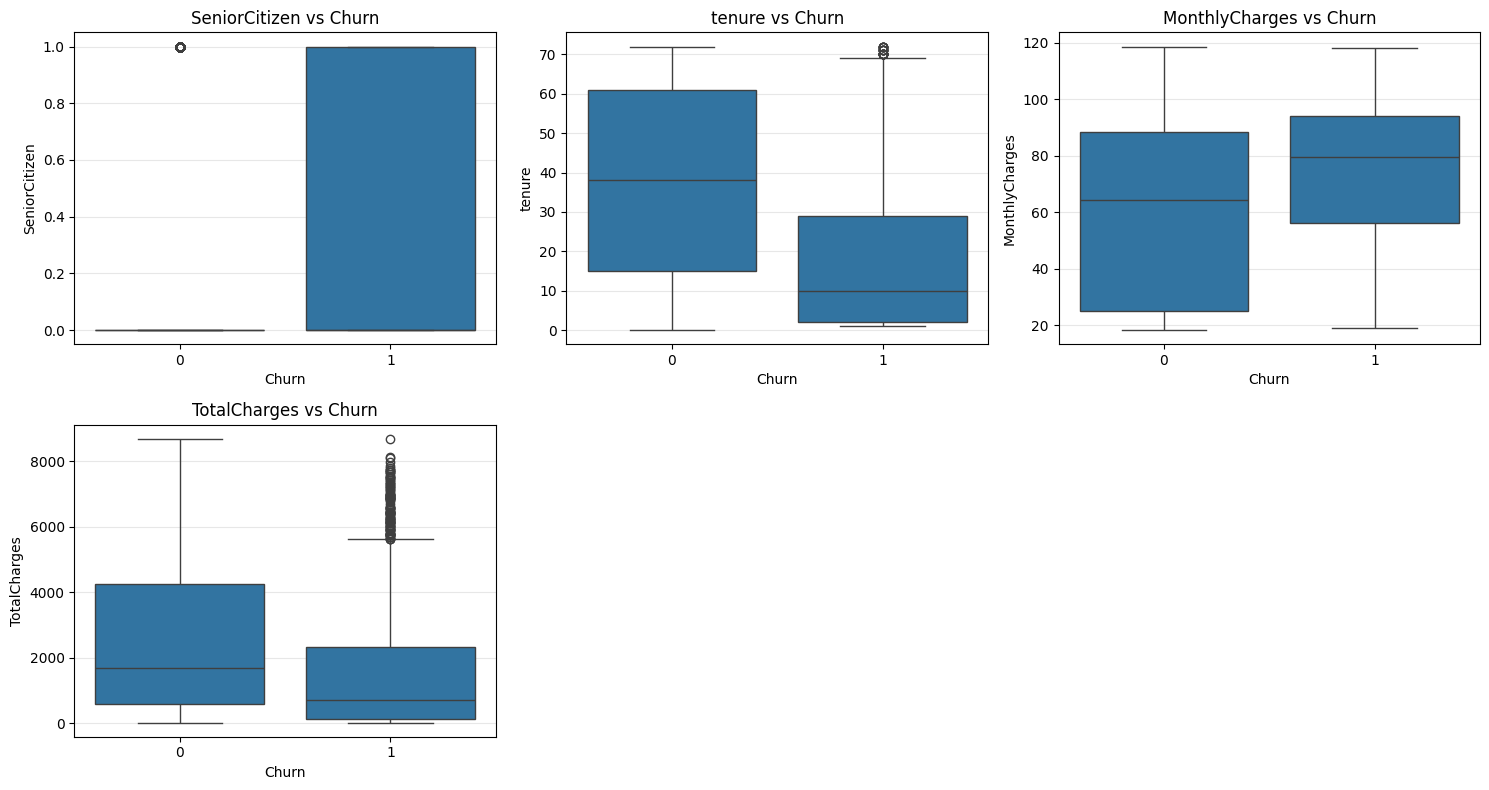

In [75]:

n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, x="Churn", y=col, ax=ax)
    ax.set_title(f"{col} vs Churn")
    ax.set_xlabel("Churn")
    ax.set_ylabel(col)
    ax.grid(axis="y", alpha=0.3)

for ax in axes[len(num_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Клиенты с churn имеют заметно меньший tenure и более высокие MonthlyCharges, что указывает на связь краткого срока обслуживания и дорогих тарифов с повышенной вероятностью ухода. Также у них ниже TotalCharges, что логично, поскольку они не успели накопить большие платежи.

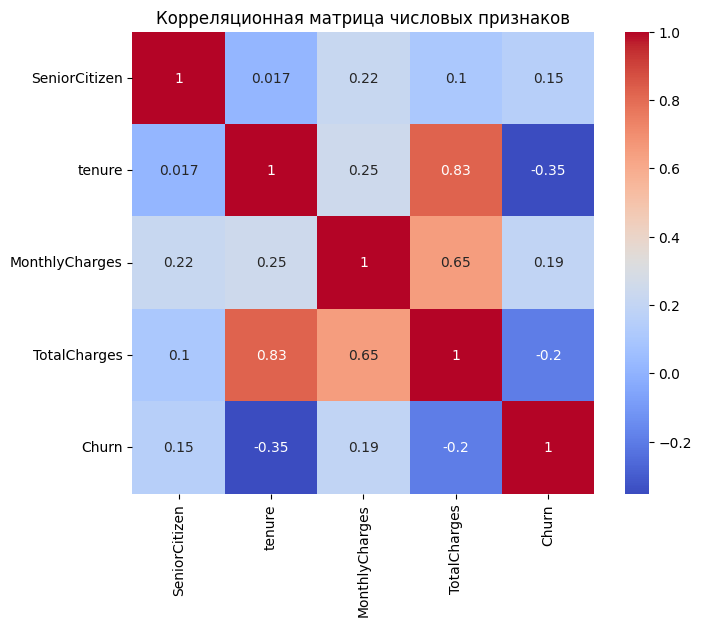

In [76]:

corr = df[num_cols + ["Churn"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, 
    annot=True, 
    cmap="coolwarm", 
    square=True,
    cbar=True
)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

Корреляционная матрица показывает, что tenure и TotalCharges ожидаемо сильно связаны, поскольку накопленные платежи растут с длительностью обслуживания. С Churn наиболее заметно отрицательно коррелирует tenure — клиенты с небольшим стажем чаще уходят. Другие числовые признаки имеют слабую связь с целевой переменной, что указывает на необходимость использования моделей, способных учитывать нелинейные зависимости.

Теперь формируем признаковое пространство и разбиение: удаляем customerID, отделяем целевую переменную Churn, делаем стратифицированный train/test-сплит (20%). Готовим два препроцессинга: для деревьев — имьютация медианой для чисел и One-Hot для категорий (preproc_trees), для SVM/KNN — то же плюс масштабирование чисел StandardScaler (preproc_svm_knn). Для CatBoost определяем индексы категориальных признаков (cat_features_idx), задаём компактную сетку гиперпараметров (depth, learning_rate, iterations) и настраиваем стратифицированную 5-fold кросс-валидацию; обучающую выборку упаковываем в Pool.

In [77]:
TARGET = "Churn"
ID_COLS = ["customerID"] if "customerID" in df.columns else []

X = df.drop(columns=[TARGET] + ID_COLS)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [78]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preproc_trees = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
)

In [79]:
num_pipe_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preproc_svm_knn = ColumnTransformer(
    transformers=[
        ("num", num_pipe_scaled, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
)

In [80]:
cat_features_idx = [X.columns.get_loc(c) for c in cat_cols]

In [81]:
param_grid = [
    {"depth": 4, "learning_rate": 0.1, "iterations": 600},
    {"depth": 6, "learning_rate": 0.05, "iterations": 800},
    {"depth": 8, "learning_rate": 0.03, "iterations": 1000},
]

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [83]:
train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)

Перебираем заданные конфигурации гиперпараметров CatBoost с использованием встроенной кросс-валидации. Для каждой комбинации выполняем 5-fold CV с ранней остановкой, после чего фиксируем лучший ROC-AUC и соответствующее число итераций. Результаты собираем в таблицу, что позволяет выбрать оптимальные параметры для финального обучения модели.

In [84]:
results = []

for params in param_grid:
    print(f"Проверяем параметры: {params}")

    cv_results = cv(
        params={
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "random_seed": 42,
            "early_stopping_rounds": 50,
            **params
        },
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    best_auc = cv_results["test-AUC-mean"].max()
    best_iter = cv_results["test-AUC-mean"].idxmax()

    results.append({
        "params": params,
        "best_auc": best_auc,
        "best_iter": best_iter
    })

results_df = pd.DataFrame(results)
results_df


Проверяем параметры: {'depth': 4, 'learning_rate': 0.1, 'iterations': 600}
Training on fold [0/5]

bestTest = 0.8684847236
bestIteration = 106

Training on fold [1/5]

bestTest = 0.8321700354
bestIteration = 148

Training on fold [2/5]

bestTest = 0.851707786
bestIteration = 88

Training on fold [3/5]

bestTest = 0.8548361689
bestIteration = 70

Training on fold [4/5]

bestTest = 0.8440347308
bestIteration = 260

Проверяем параметры: {'depth': 6, 'learning_rate': 0.05, 'iterations': 800}
Training on fold [0/5]

bestTest = 0.8670164639
bestIteration = 132

Training on fold [1/5]

bestTest = 0.8289507699
bestIteration = 77

Training on fold [2/5]

bestTest = 0.8498093484
bestIteration = 97

Training on fold [3/5]

bestTest = 0.8553935825
bestIteration = 51

Training on fold [4/5]

bestTest = 0.842360468
bestIteration = 259

Проверяем параметры: {'depth': 8, 'learning_rate': 0.03, 'iterations': 1000}
Training on fold [0/5]

bestTest = 0.8671497585
bestIteration = 179

Training on fold [1/

,params,best_auc,best_iter
0,"{'depth': 4, 'learning_rate': 0.1, 'iterations...",0.849032,148
1,"{'depth': 6, 'learning_rate': 0.05, 'iteration...",0.848564,259
2,"{'depth': 8, 'learning_rate': 0.03, 'iteration...",0.848585,142


извлекаем лучшую найденную конфигурацию CatBoost, удаляем параметр iterations, так как оптимальное число итераций уже определено кросс-валидацией, и создаём финальную модель с этими настройками. Затем модель обучается на всей тренировочной выборке, упакованной в Pool.

In [85]:
best_cfg = results_df.iloc[results_df["best_auc"].idxmax()]
best_cfg

params       {'depth': 4, 'learning_rate': 0.1, 'iterations...
best_auc                                              0.849032
best_iter                                                  148
Name: 0, dtype: object

In [86]:
best_params = best_cfg["params"].copy()
best_params.pop("iterations")
best_iter = int(best_cfg["best_iter"])

model_cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    iterations=best_iter,
    **best_params
)

model_cat.fit(train_pool, verbose=False)


Также для случайного леса подбираем кросс-валидацией гиперпараметры через GridSearchCV и определяем лучшую конфигурацию

In [87]:
rf_param_grid = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [None, 10, 15],
    "model__min_samples_leaf": [1, 3]
}

In [88]:
rf_pipeline = Pipeline([
    ("preprocess", preproc_trees),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [89]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [90]:
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__min_samples_leaf': [1, 3], 'model__n_estimators': [200, 400, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [91]:
best_rf = rf_grid.best_estimator_
best_rf_params = rf_grid.best_params_
best_rf_score = rf_grid.best_score_

best_rf_params, best_rf_score

({'model__max_depth': 10,
  'model__min_samples_leaf': 3,
  'model__n_estimators': 800},
 np.float64(0.8452849518294346))

Аналогично для SVM и kNN

In [92]:
svc_param_grid = {
    "model__C": [0.5, 1, 2, 4],
    "model__kernel": ["rbf"],
}

In [93]:
svc_pipeline = Pipeline([
    ("preprocess", preproc_svm_knn),
    ("model", SVC(
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])

In [94]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [95]:
svc_grid = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_param_grid,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.5, 1, ...], 'model__kernel': ['rbf']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [96]:
best_svc = svc_grid.best_estimator_
best_svc_params = svc_grid.best_params_
best_svc_score = svc_grid.best_score_

best_svc_params, best_svc_score

({'model__C': 0.5, 'model__kernel': 'rbf'}, np.float64(0.8322140234176816))

In [97]:
knn_param_grid = {
    "model__n_neighbors": [5, 9, 15, 25],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

In [98]:
knn_pipeline = Pipeline([
    ("preprocess", preproc_svm_knn),
    ("model", KNeighborsClassifier())
])

In [99]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [100]:
knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__n_neighbors': [5, 9, ...], 'model__p': [1, 2], 'model__weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [101]:
best_knn = knn_grid.best_estimator_
best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

best_knn_params, best_knn_score

({'model__n_neighbors': 25, 'model__p': 2, 'model__weights': 'uniform'},
 np.float64(0.8319873215684025))

Рассчитываем основные метрики для моделей

In [102]:
def evaluate_model(name, model, X_test, y_test, proba=True):
    if name == "CatBoost":
        y_pred = model.predict(Pool(X_test, cat_features=cat_features_idx))
        y_proba = model.predict_proba(Pool(X_test, cat_features=cat_features_idx))[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if proba else None

    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }


In [103]:
results = []

results.append(evaluate_model("CatBoost", model_cat, X_test, y_test))
results.append(evaluate_model("RandomForest", best_rf, X_test, y_test))
results.append(evaluate_model("SVC", best_svc, X_test, y_test))
results.append(evaluate_model("KNN", best_knn, X_test, y_test))

df_results = pd.DataFrame(results)
df_results


,model,accuracy,precision,recall,f1,roc_auc
0,CatBoost,0.804826,0.668942,0.524064,0.587706,0.846785
1,RandomForest,0.767921,0.546906,0.732620,0.626286,0.841058
2,SVC,0.743790,0.511304,0.786096,0.619600,0.825052
3,KNN,0.784954,0.598886,0.574866,0.586630,0.827011


По метрикам видно следующее. CatBoost показывает лучший баланс между показателями, особенно по ROC-AUC и precision, в то время как RandomForest и SVC имеют повышенный recall. KNN демонстрирует средние, но стабильные результаты.

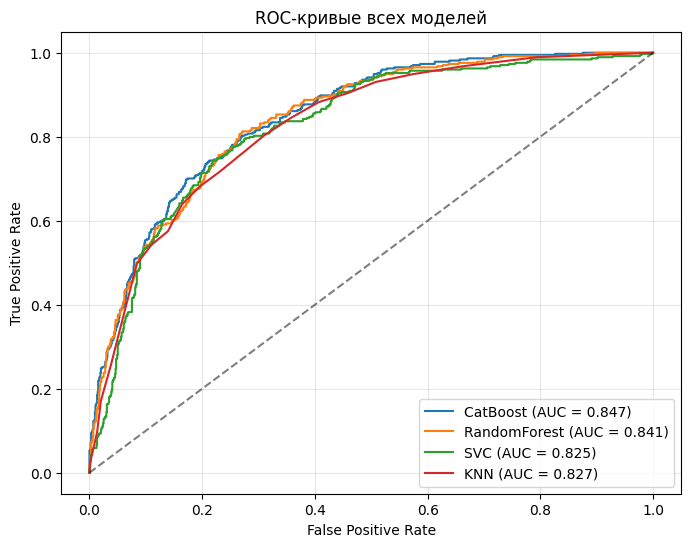

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

y_proba = model_cat.predict_proba(Pool(X_test, cat_features=cat_features_idx))[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {auc(fpr, tpr):.3f})")

y_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"RandomForest (AUC = {auc(fpr, tpr):.3f})")

y_proba = best_svc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"SVC (AUC = {auc(fpr, tpr):.3f})")

y_proba = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"KNN (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые всех моделей")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


По ROC-кривой видно, что CatBoost даёт наилучший результат, а RandomForest находится очень близко. SVC и KNN показывают умеренное, но стабильное качество. Чем выше кривая и больше AUC, тем лучше модель различает клиентов, склонных к уходу.

Выведем Precision-matrix

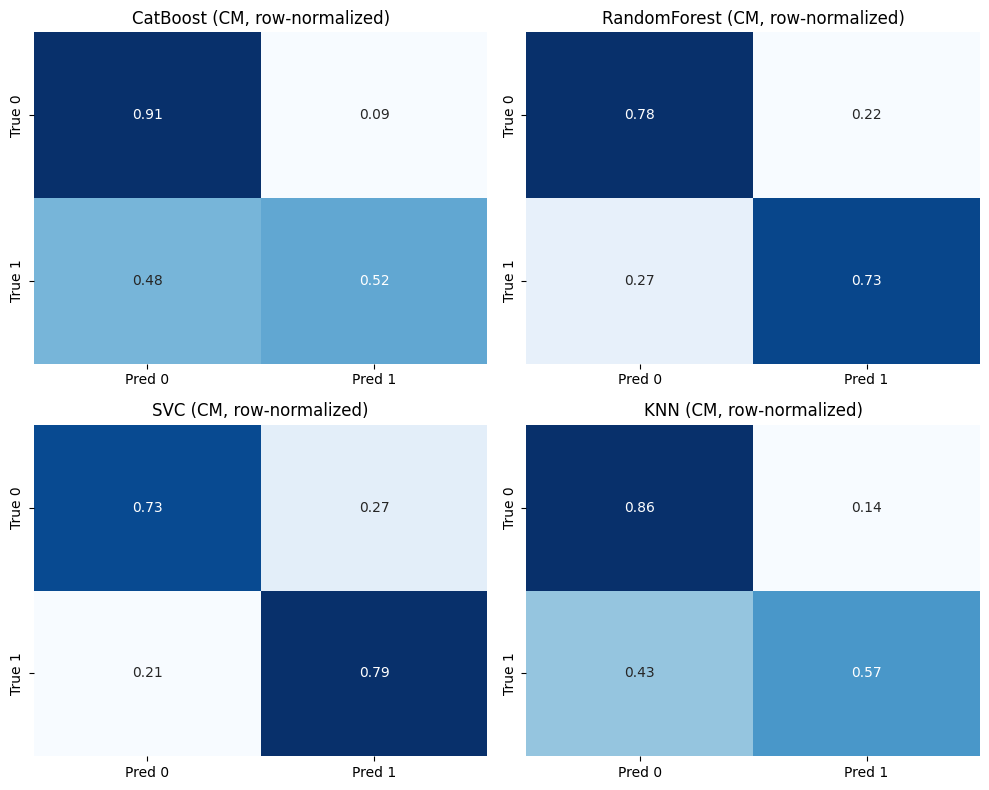

In [105]:
def plot_cm(ax, y_true, y_pred, title, normalize=True):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")

y_pred_cat = model_cat.predict(Pool(X_test, cat_features=cat_features_idx))
y_pred_rf  = best_rf.predict(X_test)
y_pred_svc = best_svc.predict(X_test)
y_pred_knn = best_knn.predict(X_test)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

plot_cm(axes[0], y_test, y_pred_cat, "CatBoost (CM, row-normalized)")
plot_cm(axes[1], y_test, y_pred_rf,  "RandomForest (CM, row-normalized)")
plot_cm(axes[2], y_test, y_pred_svc, "SVC (CM, row-normalized)")
plot_cm(axes[3], y_test, y_pred_knn, "KNN (CM, row-normalized)")

plt.tight_layout()
plt.show()

RandomForest и SVC лучше остальных находят клиентов, которые действительно уходят (True 1), в то время как CatBoost и KNN чуть лучше распознают остающихся клиентов (True 0). Это отражает разные балансы между precision и recall у моделей.

Еще раз посмотрим на метрики моделей, но через heatmap

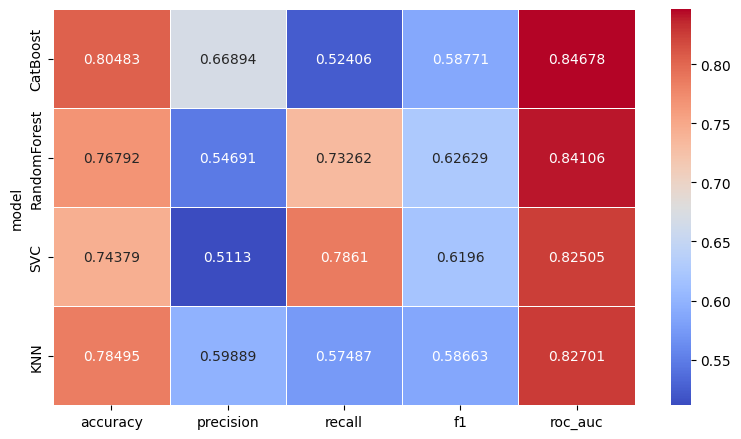

In [106]:
df_hm = df_results.copy()
df_hm = df_hm.set_index("model")

plt.figure(figsize=(8, 4.5))

sns.heatmap(
    df_hm,
    annot=True,
    fmt='.5g',
    cmap="coolwarm",
    linewidths=.5,
    cbar=True
)

plt.tight_layout()
plt.show()

CatBoost демонстрирует наиболее сбалансированное качество и лучший результат по ROC-AUC и precision, тогда как RandomForest и SVC лучше справляются с обнаружением клиентов, склонных к уходу (более высокий recall). В целом, по совокупности метрик оптимальным выбором для задачи предсказания оттока является модель CatBoost.

CatBoost показывает лучшие результаты из-за того, что его архитектура специально оптимизирована под данные с большим количеством категориальных признаков, а в Telco Customer Churn их большинство. В отличие от RandomForest, SVC и KNN, CatBoost не использует простое One-Hot кодирование, а применяет упорядоченное target-based кодирование (ordinal / target statistics), которое сохраняет информацию и уменьшает шум на редких категориях. Это позволяет модели эффективнее извлекать зависимости между категориями и целевым признаком.

Кроме того, CatBoost обучается на симметричных деревьях, что делает его менее склонным к переобучению и более устойчивым на данных с шумом и несбалансированными категориями. Его встроенный механизм Ordered Boosting предотвращает утечку целевой переменной, что особенно важно при использовании категориальных признаков.